The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.14.3


# Networks Using Blocks (VGG)
:label:`sec_vgg`

While AlexNet offered empirical evidence that deep CNNs
can achieve good results, it did not provide a general template
to guide subsequent researchers in designing new networks.
In the following sections, we will introduce several heuristic concepts
commonly used to design deep networks.

Progress in this field mirrors that in chip design
where engineers went from placing transistors
to logical elements to logic blocks.
Similarly, the design of neural network architectures
had grown progressively more abstract,
with researchers moving from thinking in terms of
individual neurons to whole layers,
and now to blocks, repeating patterns of layers.

The idea of using blocks first emerged from the
[Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) (VGG)
at Oxford University,
in their eponymously-named *VGG* network.
It is easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.


## VGG Blocks

The basic building block of classic CNNs
is a sequence of the following:
(i) a convolutional layer
with padding to maintain the resolution,
(ii) a nonlinearity such as a ReLU,
(iii) a pooling layer such
as a max pooling layer.
One VGG block consists of a sequence of convolutional layers,
followed by a max pooling layer for spatial downsampling.
In the original VGG paper :cite:`Simonyan.Zisserman.2014`,
the authors
employed convolutions with $3\times3$ kernels with padding of 1 (keeping height and width)
and $2 \times 2$ max pooling with stride of 2
(halving the resolution after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.
The function takes two arguments
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.


In [1]:
from d2l import torch as d2l
import torch
from torch import nn

def vgg_block(num_convs, in_channels, out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

## VGG Network

Like AlexNet and LeNet,
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and the second consisting of fully-connected layers.
This is depicted in :numref:`fig_vgg`.

![From AlexNet to VGG that is designed from building blocks.](http://d2l.ai/_images/vgg.svg)
:width:`400px`
:label:`fig_vgg`


The convolutional part of the network connects several VGG blocks from :numref:`fig_vgg` (also defined in the `vgg_block` function)
in succession.
The following variable `conv_arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function.
The fully-connected part of the VGG network is identical to that covered in AlexNet.

The original VGG network had 5 convolutional blocks,
among which the first two have one convolutional layer each
and the latter three contain two convolutional layers each.
The first block has 64 output channels
and each subsequent block doubles the number of output channels,
until that number reaches 512.
Since this network uses 8 convolutional layers
and 3 fully-connected layers, it is often called VGG-11.


In [2]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

The following code implements VGG-11. This is a simple matter of executing a for-loop over `conv_arch`.


In [3]:
def vgg(conv_arch):
    # The convolutional part
    conv_blks=[]
    in_channels=1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

Next, we will construct a single-channel data example
with a height and width of 224 to observe the output shape of each layer.


In [4]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As you can see, we halve height and width at each block,
finally reaching a height and width of 7
before flattening the representations
for processing by the fully-connected part of the network.

## Training

Since VGG-11 is more computationally-heavy than AlexNet
we construct a network with a smaller number of channels.
This is more than sufficient for training on Fashion-MNIST.


In [5]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

Apart from using a slightly larger learning rate,
the model training process is similar to that of AlexNet in :numref:`sec_alexnet`.


loss 0.177, train acc 0.933, test acc 0.917
1907.6 examples/sec on cuda:0


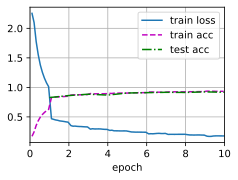

In [6]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* VGG-11 constructs a network using reusable convolutional blocks. Different VGG models can be defined by the differences in the number of convolutional layers and output channels in each block.
* The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.
* In their VGG paper, Simonyan and Ziserman experimented with various architectures. In particular, they found that several layers of deep and narrow convolutions (i.e., $3 \times 3$) were more effective than fewer layers of wider convolutions.

## Exercises

1. When printing out the dimensions of the layers we only saw 8 results rather than 11. Where did the remaining 3 layer information go?
1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory. Analyze the reasons for this.
1. Try changing the height and width of the images in Fashion-MNIST from 224 to 96. What influence does this have on the experiments?
1. Refer to Table 1 in the VGG paper :cite:`Simonyan.Zisserman.2014` to construct other common models, such as VGG-16 or VGG-19.


[Discussions](https://discuss.d2l.ai/t/78)
